# Confusion Matrix Visualization

0
0


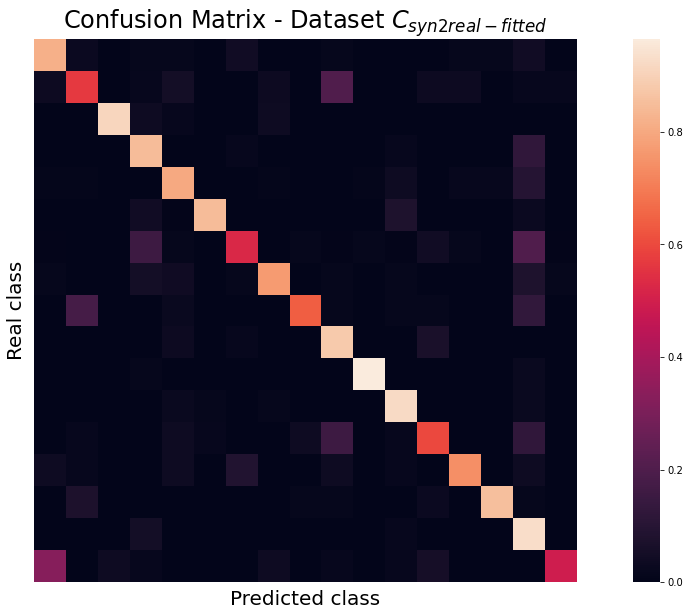

In [4]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import sys
import seaborn as sns
from sklearn.metrics import confusion_matrix
from modules import visualization

run="sn17_ilsvrc"
feature_extractor="vit_in21k"
split="syn2real"
DPI = 96
def vis_confusion_matrix(confusion_matrix, labels_x: list, labels_y: list, out_path: str,title: str="Confusion Matrix", size_px: tuple = (1920, 960)):
    plt.figure(figsize=(int(size_px[0] / DPI), int(size_px[1] / DPI)))
    ax = sns.heatmap(
        data=confusion_matrix,
        # cmap='Blues',
        cbar=True,
        robust=False,
        annot=False,
        linewidths=0,
        xticklabels=False,
        yticklabels=False,
        square=True
    )
    ax.set_title(title,fontsize=24)

    plt.xlabel('Predicted class', fontsize=20)
    plt.ylabel('Real class', fontsize=20)
    # plt.title('Confusion Matrix')
    


dataset_df = pd.read_csv(f"out/{run}/{feature_extractor}/{split}/dataset.csv")
labels = dataset_df['class_label'].unique()
eval_data_df = pd.read_pickle(f"out/{run}/{feature_extractor}/{split}/eval_results/eval_data.pickle")


# cm = np.load(f"out/{dataset}/{split}/{feature_extractor}/eval_results/conf_mat_norm_true.npy")
cm = confusion_matrix(
    eval_data_df['y_true'].values,
    eval_data_df['y_pred1'].values,
    labels=labels,
    normalize='true',
)

delete_row = [y for y, row in enumerate(cm) if sum(row) == 0 and labels[y] not in eval_data_df['y_true'].unique()]
delete_col = [
    y for y, _ in enumerate(cm) if sum(cm[:, y]) == 0 and labels[y] not in eval_data_df['y_true'].unique()
]
cm = np.delete(np.delete(cm, delete_row, axis=0), delete_col, axis=1)
print(len(delete_row))
print(len(delete_col))
labels_x = np.delete(labels, delete_col, axis=0)
labels_y = np.delete(labels, delete_row, axis=0)
vis_confusion_matrix(cm, labels_x, labels_y, title=r'Confusion Matrix - Dataset $C_{syn2real}$',out_path=None)
plt.show()

### Confusion Matrix from WandB confmat json Artifat

['aeroplane', 'bicycle', 'bus', 'car', 'horse', 'knife', 'motorcycle', 'person', 'plant', 'skateboard', 'train', 'truck']


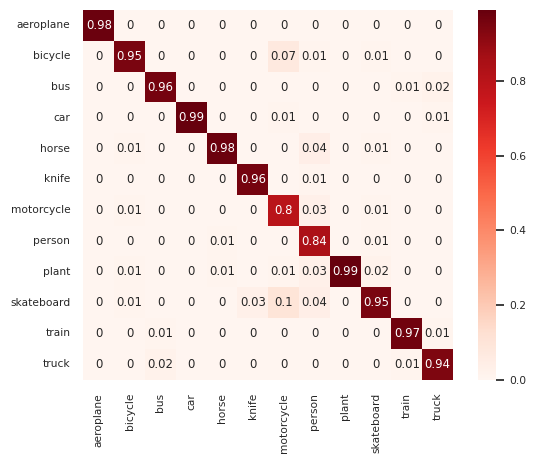

In [50]:
import numpy as np
import pandas as pd
import json
from matplotlib import pyplot as plt
import sys
import seaborn as sns
from sklearn.metrics import confusion_matrix
from modules import visualization

# A WandB artifact .json file including all confmat values already.
cm_json_path = '/home/dennis/Desktop/confusion_matrix_61_01a1b054d877463b9903.table.json'
with open(cm_json_path) as cm_json_path:
    cm_json = json.load(cm_json_path)
    
cols = list(d[0] for d in cm_json['data'][::12])
print(cols)
data = np.array([d[2] for d in cm_json['data']]).reshape(len(cols), len(cols))
df = pd.DataFrame(data, columns=cols)
sns.set(font_scale=0.7)
cmap = sns.cm.rocket_r
p1t = sns.heatmap(data.transpose(), xticklabels=cols, yticklabels=cols, annot=True, square=True, cbar=True, robust=False, cmap=cmap)
plt.show()


# # Create a dataset
# df = pd.DataFrame(np.random.random((5,5)), columns=["a","b","c","d","e"])
# # Default heatmap

# Show classifications example cases as grid

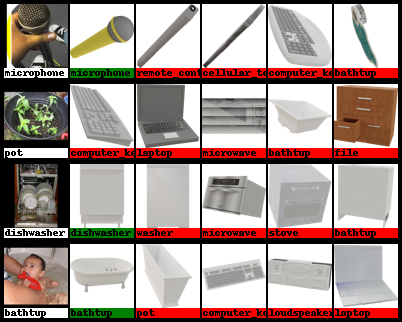

In [85]:
import pandas as pd
import numpy as np
from PIL import Image, ImageOps, ImageDraw, ImageFont
from torchvision import transforms as transforms
from torchvision.io import read_image
from torchvision.utils import make_grid
import random


CLASS=None
N = 10
# ['WRONG', 'CORRECT', 'RANDOM']
MODE='RANDOM'
SHOW_CLASS_TEXT = True
SIZE=(128, 128)
# top, right, bottom, left
BORDER=(0,0,0,10)
run="sn17_ilsvrc"
feature_extractor="vit_in21k"
split="syn2real"

dataset_df = pd.read_csv(f"out/{run}/{feature_extractor}/{split}/dataset.csv")
eval_data = pd.read_pickle(f"./out/{run}/{feature_extractor}/{split}/eval_results/eval_data.pickle")

if CLASS:
    eval_data = eval_data.loc[eval_data["y_true"] == CLASS]

if MODE == 'CORRECT':
    eval_data = eval_data.loc[eval_data.apply(lambda x:x["y_true"] in x["y_pred5"], axis=1)].reset_index(drop=True)
if MODE == 'WRONG':
    eval_data = eval_data.loc[eval_data.apply(lambda x:x["y_true"] not in x["y_pred5"], axis=1)].reset_index(drop=True)

# Sample N random rows from eval_data
eval_data = eval_data.sample(n=N)

# Load images, process, and make grid row
grid_rows = []
for i, row in eval_data.iterrows():
    # Get query image and predictions path
    test_path = row['image']
    pred_paths = list(row['y_pred5_im'])
    # Get predictions
    y_true = row["y_true"]
    y_pred5 = row["y_pred5"]

    # Load images
    test_im = Image.open(test_path)
    pred_ims = [Image.open(p) for p in pred_paths]

    # Process test image
    # Resize
    test_im = test_im.resize(SIZE)
    # Border (to match size for grid creation)
    test_im = ImageOps.expand(test_im, border=BORDER, fill="white")
    # Add class name text
    if SHOW_CLASS_TEXT:
            font = ImageFont.load_default()
            text = y_true
            edit = ImageDraw.Draw(test_im)
            edit.text((1,test_im.size[1]-font.getsize(text)[1]), text, (0,0,0), font=font)
    # Convert to RGB
    test_im = test_im.convert("RGB")

    # Process prediction images
    for i, im in enumerate(pred_ims):
        # Resize
        im = im.resize(SIZE)
        # White background
        white_bg = Image.new("RGBA", im.size, "WHITE")
        white_bg.paste(im, (0, 0), im)
        im = white_bg
        # Add color border for images depending of right/wrong prediction
        if y_true == y_pred5[i]:
            im = ImageOps.expand(im, border=BORDER, fill="green")
        else:
            im = ImageOps.expand(im, border=BORDER, fill="red")
        # Add class name text
        if SHOW_CLASS_TEXT:
            font = ImageFont.load_default()
            text = y_pred5[i]
            edit = ImageDraw.Draw(im)
            edit.text((1,im.size[1]-font.getsize(text)[1]), text, (0,0,0), font=font)
        # Convert to RGB
        im = im.convert("RGB")
        pred_ims[i] = im

    # Make grid_row
    ims = [test_im] + pred_ims
    tensor_ims = [transforms.ToTensor()(im) for im in ims]
    grid_row = make_grid(tensor_ims, nrow=len(tensor_ims))
    grid_rows.append(grid_row)

grid = make_grid(grid_rows, nrow=1)
transforms.ToPILImage()(grid)


# TSNE Plots

/home/dritter/miniconda3/envs/py39-evaluation-pipeline/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:991: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


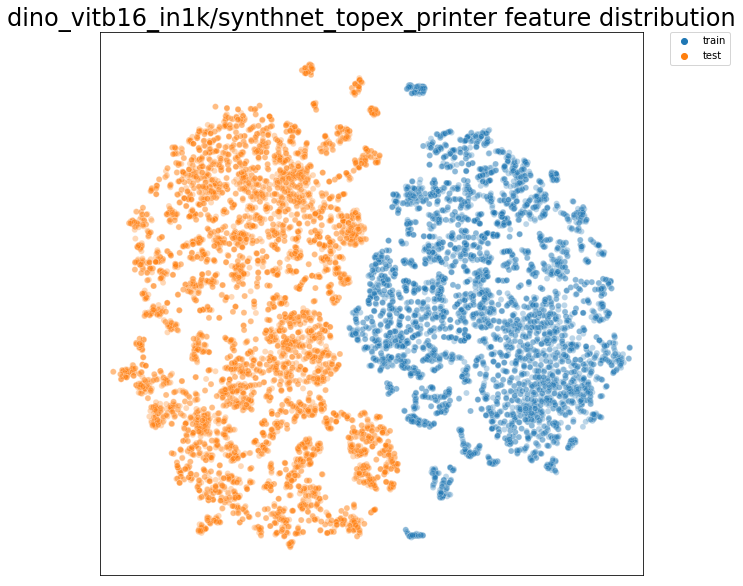

In [2]:
import numpy as np
from sklearn.manifold import TSNE
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

run="synthnet_topex_printer"
feature_extractor="dino_vitb16_in1k"
split="traintest_full"

# X = np.array([[0, 0, 0], [0, 1, 1], [1, 0, 1], [1, 1, 1]])
df_train = pd.read_pickle(f'out/{run}/{feature_extractor}/{split}/features_train.pickle')
df_test = pd.read_pickle(f'out/{run}/{feature_extractor}/{split}/features_test.pickle')
X_train = [x for x in df_train.values()]
label_train = ['train'] * len(X_train)
X_test = [x for x in df_test.values()]
label_test = ['test'] * len(X_test)

X = np.array(X_train + X_test)
labels = np.array(label_train + label_test)

X_embedded = TSNE(n_components=2, learning_rate='auto', init='pca').fit_transform(X)
X_embedded.shape

DPI = 96
size_px = (1024, 1024)
# Plot the result of our TSNE with the label color coded
# A lot of the stuff here is about making the plot look pretty and not TSNE
tsne_result_df = pd.DataFrame({'tsne_1': X_embedded[:,0], 'tsne_2': X_embedded[:,1], 'label': labels})
plt.figure(figsize=(int(size_px[0] / DPI), int(size_px[1] / DPI)))
ax = sns.scatterplot(
    data=tsne_result_df,
    x='tsne_1', 
    y='tsne_2', 
    hue='label',
    markers='o',
    alpha=.3) 
lim = (X_embedded.min()-5, X_embedded.max()+5)
ax.set_xlim(lim)
ax.set_ylim(lim)
ax.set_aspect('equal')
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)
plt.gca().axes.get_yaxis().set_visible(False)
plt.gca().axes.get_xaxis().set_visible(False)

# title = r'$sn17-ilsvrc_{syn2real}$ feature distribution'
title = f'{feature_extractor}/{run} feature distribution'
ax.set_title(title,fontsize=24)
plt.show()